# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Изучение данных из файла

In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import math
import warnings
pd.set_option('max_columns', None)
warnings.simplefilter('ignore') 

In [2]:
#на этапе чтения используем кастомный парсер даты для преобразования строковых данных в дату
custom_date_parser = lambda dates: [datetime.strptime(d, '%Y-%m-%dT%H:%M:%S') for d in dates]
data = pd.read_csv(
    '/datasets/real_estate_data.csv',
    sep='\t',
    parse_dates=['first_day_exposition'],
    date_parser=custom_date_parser
)

In [3]:
data.head()
initial_dataset_lenght = len(data)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null datetime64[ns]
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_a

In [5]:
data.dtypes.value_counts()

float64           14
int64              3
object             2
bool               2
datetime64[ns]     1
dtype: int64

In [6]:
#для простоты восприятия инвертируем информацию о заполненных значениях в методе info 
#и выведем сумму пропуском по каждому из столбцов
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [7]:
print('Количество полных дубликатов в сете:', sum(data.duplicated()))

Количество полных дубликатов в сете: 0


### Вывод

1. Датасет состоит из следующих строк:
    + `airports_nearest` — расстояние до ближайшего аэропорта в метрах (м)
    + `balcony` — число балконов
    + `ceiling_height` — высота потолков (м)
    + `cityCenters_nearest` — расстояние до центра города (м)
    + `days_exposition` — сколько дней было размещено объявление (от публикации до снятия)
    + `first_day_exposition` — дата публикации
    + `floor` — этаж
    + `floors_total` — всего этажей в доме
    + `is_apartment` — апартаменты (булев тип)
    + `kitchen_area` — площадь кухни в квадратных метрах (м²)
    + `last_price` — цена на момент снятия с публикации
    + `living_area` — жилая площадь в квадратных метрах (м²)
    + `locality_name` — название населённого пункта
    + `open_plan` — свободная планировка (булев тип)
    + `parks_around3000` — число парков в радиусе 3 км
    + `parks_nearest` — расстояние до ближайшего парка (м)
    + `ponds_around3000` — число водоёмов в радиусе 3 км
    + `ponds_nearest` — расстояние до ближайшего водоёма (м)
    + `rooms` — число комнат
    + `studio` — квартира-студия (булев тип)
    + `total_area` — площадь квартиры в квадратных метрах (м²)
    + `total_images` — число фотографий квартиры в объявлении
2. В файле содержатся 22699 строк и 22 столбца
3. Только в 8 из 22 столбцов нет пропусков. Следовательно, потребуется трудоемкая работа по очистке пропусков
4. В исходном датафрейме 4 типа данных: целые числа и числа с плавающей точкой, строковый тип и булевы значения. Также мы на этапе чтения преобразовали дату в соответствующий формат.
5. Полных дубликатов в датасете нет


## Предобработка данных

### Заполнение пропусков и очистка данных

#### Столбец `first_day_exposition` 

Проверим даты в столбце:

In [8]:
print(data['first_day_exposition'].min())
print(data['first_day_exposition'].max())

2014-11-27 00:00:00
2019-05-03 00:00:00


Похоже, что с датами все в порядке.

#### Столбец `last_price`

In [9]:
data['last_price'].describe()

count    2.369900e+04
mean     6.541549e+06
std      1.088701e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64

В данном случае вызывает вопросы минимальная стоимость объекта - примерно 12190 рублей, что выглядит как ошибка в данных. 

In [10]:
data.sort_values(by='last_price').head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
8793,7,12190.0,109.0,2019-03-20,2,2.75,25.0,32.0,25,NaN,False,False,40.5,NaN,Санкт-Петербург,36421.0,9176.0,1.0,805.0,0.0,NaN,8.0
17456,7,430000.0,30.4,2019-04-22,1,NaN,2.0,16.0,1,NaN,False,False,6.0,NaN,Сланцы,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14911,5,430000.0,54.0,2018-06-26,2,NaN,3.0,NaN,3,NaN,False,False,NaN,NaN,посёлок станции Свирь,NaN,NaN,NaN,NaN,NaN,NaN,44.0
16274,18,440000.0,40.0,2018-07-10,1,NaN,5.0,NaN,1,NaN,False,False,NaN,NaN,деревня Старополье,NaN,NaN,NaN,NaN,NaN,NaN,45.0
17676,0,450000.0,36.5,2018-02-01,1,NaN,5.0,17.3,4,NaN,False,False,8.5,1.0,деревня Ям-Тесово,NaN,NaN,NaN,NaN,NaN,NaN,120.0
16219,14,450000.0,38.5,2018-07-11,2,2.65,2.0,NaN,1,NaN,False,False,NaN,NaN,деревня Вахнова Кара,NaN,NaN,NaN,NaN,NaN,NaN,45.0
9581,7,450000.0,43.4,2018-08-31,2,NaN,5.0,30.3,3,NaN,False,False,5.5,NaN,деревня Старополье,NaN,NaN,NaN,NaN,NaN,NaN,96.0
5698,7,450000.0,42.0,2017-07-31,2,NaN,1.0,23.0,1,NaN,False,False,5.8,NaN,городской посёлок Будогощь,NaN,NaN,NaN,NaN,NaN,NaN,233.0
21912,0,470000.0,37.0,2018-02-18,1,NaN,3.0,NaN,3,NaN,False,False,NaN,NaN,поселок Совхозный,NaN,NaN,NaN,NaN,NaN,NaN,45.0
18867,1,470000.0,41.0,2018-02-11,1,NaN,5.0,32.0,3,NaN,False,False,9.0,NaN,деревня Выскатка,NaN,NaN,NaN,NaN,NaN,NaN,46.0


Фактически, такой объект один. Учитывая, что он располагается в СПб и имеет площадь более 100 квадратных метров, мы можем предположить, что при вводе данных забыли ввести три нуля. Исправим эту ошибку вручную:

In [11]:
data.loc[8793, 'last_price'] = data.loc[8793, 'last_price'] * 1000

#### Столбец `ceiling_height`

In [12]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [13]:
#Проанализируем столбец ceiling_height
data['ceiling_height'].describe()

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

Наблюдаем максимальное значение на 100 метрах и минимальное на 1 метре. Это наводит на мысль об ошибках в высоте. Предположим, что для оценки рынка недвижимости нам подойдут объекты, у которых высота потолка не более 5 метров и не менее 2 метров.

In [14]:
min_ceiling_height, max_ceiling_height = 2, 5

Заполним пропуски в высоте потолка средним значением для группы по общей этажности дома.

In [15]:
ceiling_heights_by_floors = (
    data[(~data['ceiling_height'].isna()) & (data['ceiling_height'] < max_ceiling_height)]
    .groupby('floors_total')['ceiling_height']
    .agg('mean')
)

ceiling_heights_by_floors.head(5)

floors_total
1.0    2.740000
2.0    2.781502
3.0    2.885152
4.0    2.956358
5.0    2.705900
Name: ceiling_height, dtype: float64

In [16]:
mean_ceiling_height = round(data[(~data['ceiling_height'].isna()) & (data['ceiling_height'] < max_ceiling_height)]['ceiling_height'].mean(), 2)
mean_ceiling_height

2.72

In [17]:
def ceiling_height_filler(row):
    if  pd.isna(row['ceiling_height']) or row['ceiling_height'] > max_ceiling_height:
        try:
            row['ceiling_height'] = round(ceiling_heights_by_floors[row['floor']], 2)
        except:
            row['ceiling_height'] = mean_ceiling_height
    return row

In [18]:
data = data.apply(ceiling_height_filler, axis=1)

In [19]:
print('Количество пропусков высоты потолка в датасете:', data['ceiling_height'].isna().sum())

Количество пропусков высоты потолка в датасете: 0


In [20]:
#теперь оставим в датасете только объекты, высота потолка которых находится в пределах заданного нами диапазона
data = data.query('@min_ceiling_height < ceiling_height < @max_ceiling_height')
len(data)

23684

Последним шагом нормализуем значения в столбце:

In [21]:
data['ceiling_height'] = (data['ceiling_height'] // 0.05)*0.05

#### Столбец `rooms`

Изучим данные в столбце комнат:

In [22]:
data['rooms'].describe()

count    23684.000000
mean         2.070892
std          1.078516
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

Первое, что вызывает вопрос - это ноль в качестве общего количества комнат. 

In [23]:
data[data['rooms'] == 0].sort_values(by='total_area', ascending=False)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
19392,5,71000000.0,371.0,2018-07-26,0,3.55,7.0,NaN,6,NaN,False,True,NaN,NaN,Санкт-Петербург,25257.0,6060.0,1.0,761.0,1.0,584.0,90.0
20082,10,16300000.0,98.4,2017-11-08,0,3.05,5.0,60.5,2,NaN,True,False,NaN,NaN,Санкт-Петербург,26972.0,5819.0,0.0,NaN,1.0,674.0,537.0
3458,6,7400000.0,73.6,2017-05-18,0,2.70,3.0,50.0,1,NaN,True,False,NaN,0.0,Санкт-Петербург,26581.0,6085.0,0.0,NaN,1.0,348.0,60.0
21227,0,8200000.0,71.0,2017-07-21,0,2.70,5.0,68.0,5,NaN,True,False,NaN,0.0,Санкт-Петербург,20170.0,1261.0,2.0,295.0,3.0,366.0,30.0
13613,16,8100000.0,58.4,2019-04-26,0,3.25,7.0,33.0,6,NaN,True,False,NaN,NaN,Санкт-Петербург,14509.0,8288.0,0.0,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,1,1350000.0,18.8,2017-11-22,0,2.70,19.0,15.8,1,NaN,True,False,NaN,NaN,Санкт-Петербург,37636.0,14479.0,0.0,NaN,1.0,1127.0,128.0
12996,8,1900000.0,18.0,2019-01-25,0,2.55,5.0,16.0,3,NaN,True,False,NaN,NaN,Санкт-Петербург,19573.0,15772.0,2.0,149.0,2.0,496.0,10.0
716,5,1500000.0,17.0,2017-06-07,0,2.70,9.0,12.0,1,NaN,True,False,NaN,0.0,посёлок Шушары,18654.0,29846.0,0.0,NaN,0.0,NaN,40.0
9412,5,2100000.0,16.0,2017-12-10,0,2.70,6.0,13.0,1,NaN,False,True,NaN,NaN,Санкт-Петербург,20735.0,2111.0,2.0,228.0,3.0,72.0,3.0


Мы видим, что у квартир с нулем комнат площадь варьируется от почти 100 квадратных метров до 15.5
Заполним пропуски, рассчитав среднее значение площади для каждого количества комнат. 

In [24]:
avg_total_area_by_rooms = data[data['rooms'] > 0].groupby(['rooms'], as_index=False).agg({'total_area': 'mean'})
avg_total_area_by_rooms

,rooms,total_area
0,1,37.647247
1,2,55.859124
2,3,77.769226
3,4,107.610763
4,5,161.474816
5,6,201.537619
6,7,265.325424
7,8,259.233333
8,9,305.975000
9,10,259.566667


Используя наш самодельный классификатор, заполним нулевые значения количества комнат референтными при помощи специально написанной для этого функции.

In [25]:
def rooms_filler(row):
    if row['rooms'] == 0:
        for value in avg_total_area_by_rooms['total_area']:
            if row['total_area'] <= value:
                row['rooms'] = avg_total_area_by_rooms.loc[avg_total_area_by_rooms['total_area'] == value, 'rooms'].values[0]
                break
    return row


In [26]:
data = data.apply(rooms_filler, axis=1)

#### Столбец `floors_total`

In [27]:
data['floors_total'].describe()

count    23598.000000
mean        10.674167
std          6.595473
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

Мы видим, что максимальная высота здания - 60 этажей, что вызывает вопросы, но не выглядит абсолютно нереалистично. Посмотрим на гистограмму и, возможно, избавимся также от значений, у которых по общей этажности здания будет слишком мало наблюдений. 

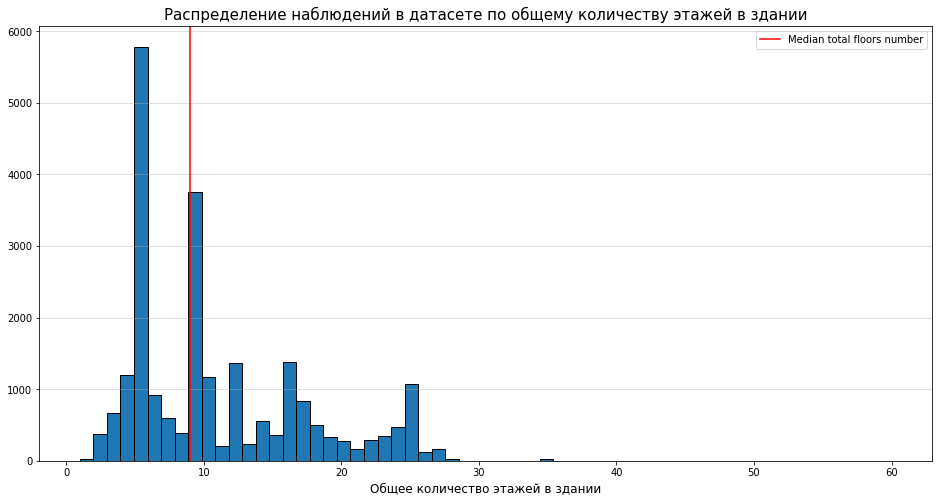

In [28]:
plt.figure(figsize=[16,8])
plt.hist(x=data['floors_total'], bins=int(data['floors_total'].max()), ec='black')
plt.grid(axis='y', alpha=0.5)
plt.xlabel('Общее количество этажей в здании',fontsize=12)
plt.axvline(x=data[(~data['floors_total'].isna())]['floors_total'].median(), color='r', label='Median total floors number')
plt.legend()
plt.title('Распределение наблюдений в датасете по общему количеству этажей в здании', fontsize=15)
plt.show()

Наблюдаем следующее: 
1. Основная масса значений сконцентрирована в пределах общего количества этажей в здании равном 30
2. После 40 этаже на гистограмме нет никаких визуально выделяющихся значений

Посчитаем общее количество объектов в датасете, у которых более 35 этажей в здании

In [29]:
len(data.query('floors_total > 35'))

5

Количество наблюдений достаточно мало для оценки его как "шум" и очистки датафрейма от него. 

In [30]:
data = data[(data['floors_total'].isna()) | (data['floors_total'] < 36)]
len(data)

23679

Повторно оценим гистограмму:

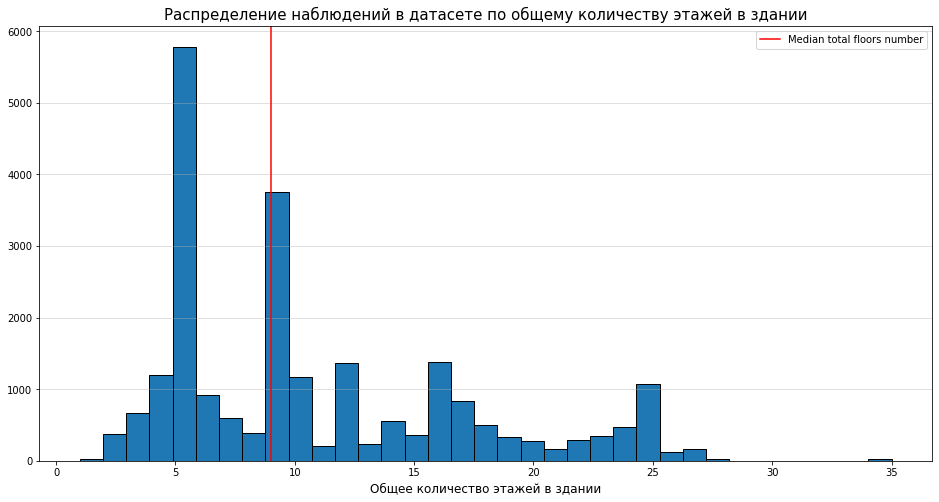

In [31]:
plt.figure(figsize=[16,8])
plt.hist(x=data['floors_total'], bins=int(data['floors_total'].max()), ec='black')
plt.grid(axis='y', alpha=0.5)
plt.xlabel('Общее количество этажей в здании',fontsize=12)
plt.axvline(x=data[(~data['floors_total'].isna())]['floors_total'].median(), color='r', label='Median total floors number')
plt.legend()
plt.title('Распределение наблюдений в датасете по общему количеству этажей в здании', fontsize=15)
plt.show()

Оценим пропуски по количеству этажей:

In [32]:
data[data['floors_total'].isna()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
186,12,11640000.0,65.2,2018-10-02,2,2.95,NaN,30.80,4,NaN,False,False,12.00,NaN,Санкт-Петербург,39197.0,12373.0,1.0,123.0,0.0,NaN,49.0
237,4,2438033.0,28.1,2016-11-23,1,2.70,NaN,20.75,1,NaN,False,False,NaN,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,251.0
457,4,9788348.0,70.8,2015-08-01,2,2.60,NaN,38.40,12,NaN,False,False,10.63,0.0,Санкт-Петербург,37364.0,8322.0,2.0,309.0,2.0,706.0,727.0
671,4,6051191.0,93.6,2017-04-06,3,2.80,NaN,47.10,8,NaN,False,False,16.80,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,123.0
1757,5,3600000.0,39.0,2017-04-22,1,2.55,NaN,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,22735.0,11618.0,1.0,835.0,1.0,652.0,77.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22542,5,8500000.0,63.5,2017-05-24,2,2.75,NaN,NaN,3,NaN,False,False,NaN,NaN,Санкт-Петербург,51340.0,15363.0,0.0,NaN,1.0,853.0,512.0
22656,4,4574160.0,64.5,2017-04-02,2,2.75,NaN,31.70,20,NaN,False,False,14.40,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,127.0
22808,0,14569263.0,110.4,2016-11-20,3,3.05,NaN,45.38,6,NaN,False,False,23.42,0.0,Санкт-Петербург,19095.0,4529.0,0.0,NaN,0.0,NaN,260.0
23590,0,21187872.0,123.3,2017-04-25,3,2.70,NaN,50.40,18,NaN,False,False,23.60,0.0,Санкт-Петербург,19095.0,4529.0,0.0,NaN,0.0,NaN,104.0


Исходя из предположения о взаимосвязи высоты потолков в здании и его этажности, а также принимая во внимание наличие всех значений в столбце с высотой потолка и малое количество записей без этаже, мы воспользуемся обратной уже использованной логикой - заполним этажность исходя из высоты потолка. 

In [33]:
floors_by_ceiling_heights = (
    data[~data['floors_total'].isna()]
    .groupby('ceiling_height')['floors_total']
    .agg('mean')
)

floors_by_ceiling_heights = floors_by_ceiling_heights.apply(lambda x: math.ceil(x))

In [34]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04,1,2.70,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20,2,2.95,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24,3,2.55,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19,2,3.00,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [35]:
floors_by_ceiling_heights.head(10)

ceiling_height
2.20     4
2.25     5
2.30     5
2.35     7
2.45     8
2.50     9
2.55    11
2.60    16
2.65    16
2.70    14
Name: floors_total, dtype: int64

Так как количество этажей в здании переменная более дискретная, чем высота потолков, то для случаев, когда не будет возможности заполнить этажность на основании средней высоты потолка, мы используем медиану. 

In [36]:
median_floors_number = int(data['floors_total'].median())

In [37]:
def floors_total_filler(row):
    if pd.isna(row['floors_total']):
        try:
            row['floors_total'] = floors_by_ceiling_heights[row['ceiling_height']]
        except:
            row['ceiling_height'] = median_floors_number
    if row['floor'] > row['floors_total']: #устраним логическую ошибку - этаж объекта больше этажности здания
        row['floors_total'] = row['floor']
    return row

In [38]:
data = data.apply(floors_total_filler, axis=1)

В итоге:
1. Удалены нерелеватные строки (шум) в данных
2. Заполнены пропуски для строк с пропусками по общей этажности здания

#### Столбец `floor`

Взглянем на значения в столбце с текущим этажом расположения объекта недвижимости:

In [39]:
data['floor'].describe()

count    23679.000000
mean         5.890240
std          4.881248
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

Данные выглядят нормально. "Нереально" больших этажей не наблюдается.

#### Столбец `total_area`

В данном столбце пропуски значений не наблюдались, поэтому проведем только исследование и очистку данных.

In [40]:
data['total_area'].describe()

count    23679.000000
mean        60.358548
std         35.664358
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

1. Минимальное значение в 12 квадратных, конечно, небольшое, но такие квартиры теоретически могут существовать как очень малогабаритное жилье
2. Максимальное значение в 900 квадратных по смыслу больше похоже на ошибку, так как вряд ли существуют такие объекты недвижимости стандартной планировки. Кроме того, такое значение скорее сместить меры центральной тенденции, которые мы можем использовать в исследовании, чем принесет пользу - рассмотрим возможность избавления от таких значений.

Для начала снова посмотрим на распределение данных по этому признаку:

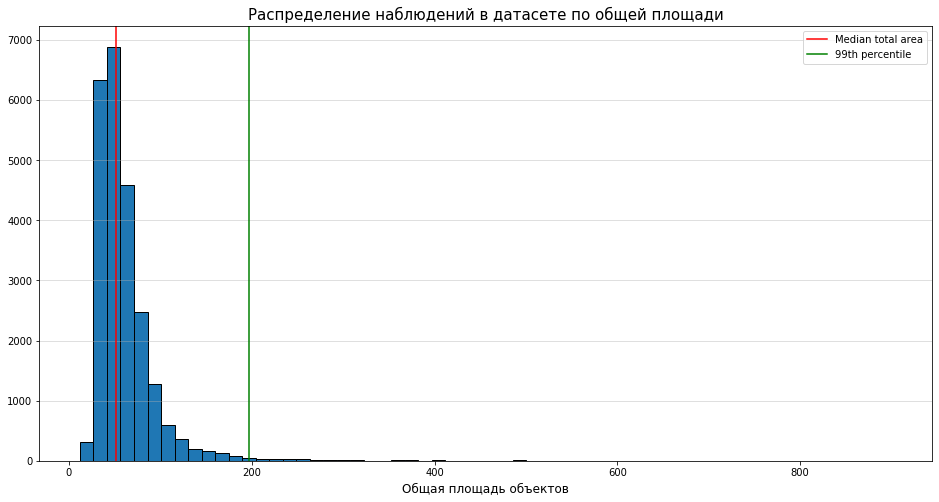

In [41]:
plt.figure(figsize=[16,8])
plt.hist(x=data['total_area'], bins=60, ec='black')
plt.grid(axis='y', alpha=0.5)
plt.xlabel('Общая площадь объектов',fontsize=12)
plt.axvline(x=data[(~data['total_area'].isna())]['total_area'].median(), color='r', label='Median total area')
plt.axvline(x=np.percentile(data['total_area'], 99), color='g', label='99th percentile')
plt.legend()
plt.title('Распределение наблюдений в датасете по общей площади', fontsize=15)
plt.show()

Мы видим, что после отметки в 200 квадратных метров количество наблюдений становится исчезающе малым. 99-й процентиль лежит у отметки в 197 квадратных метров общей площади.

In [42]:
print('99-й процентиль по общей площади объекта составляет:', np.percentile(data['total_area'], 99))
print('Удаление данных за 99м процентилем уберет из датасета следующее количество наблюдений:', len(data[data['total_area'] > np.percentile(data['total_area'], 99)]))

99-й процентиль по общей площади объекта составляет: 197.3540000000008
Удаление данных за 99м процентилем уберет из датасета следующее количество наблюдений: 237


In [43]:
data = data[data['total_area'] < np.percentile(data['total_area'], 99)]

Повторно построим распределение:

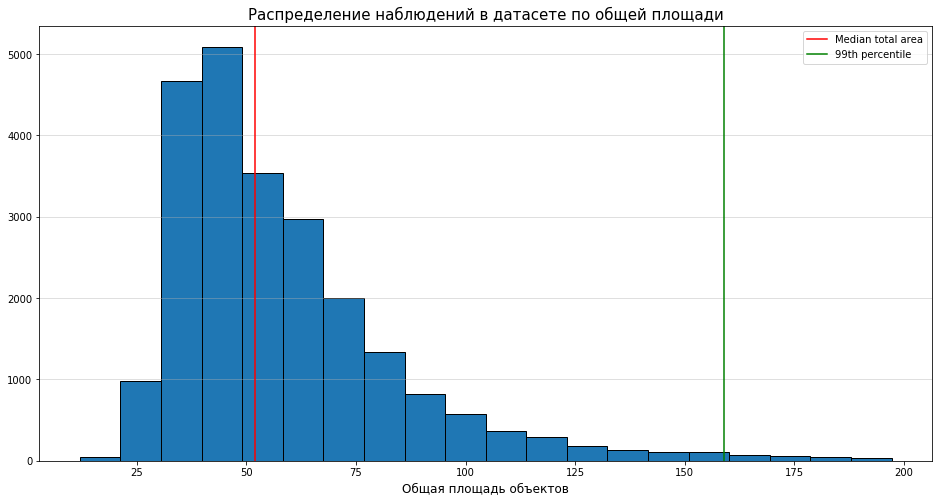

In [44]:
plt.figure(figsize=[16,8])
plt.hist(x=data['total_area'], bins=20, ec='black')
plt.grid(axis='y', alpha=0.5)
plt.xlabel('Общая площадь объектов',fontsize=12)
plt.axvline(x=data[(~data['total_area'].isna())]['total_area'].median(), color='r', label='Median total area')
plt.axvline(x=np.percentile(data['total_area'], 99), color='g', label='99th percentile')
plt.legend()
plt.title('Распределение наблюдений в датасете по общей площади', fontsize=15)
plt.show()

Мы видим, что хоть распределение и не приняло форму нормального в полном виде но стало ближе к нему. "Хвост" наблюдений свидетельствует о наличии некоторого количества люксовых объектов, что звучит нормально, когда мы говорим об анализе предложений на рынке недвижимости. 

#### Столбец `living_area`

In [45]:
print('Доля пропусков в столбце living area: {:.2f}%'.format(data['living_area'].isna().sum() / len(data)*100))

Доля пропусков в столбце living area: 7.97%


В данном столбце наблюдается порядка 8% пропусков. С точки зрения здравого смысла пропусков в данном столбце быть не должно, так как "жилая" площадь есть в любой квартире. Следовательно, рассмотрим столбец на предмет выбросов и попробуем оценить возможности по его заполнению. 

In [46]:
data['living_area'].describe()

count    21573.000000
mean        33.231714
std         17.309041
min          2.000000
25%         18.600000
50%         30.000000
75%         42.000000
max        164.700000
Name: living_area, dtype: float64

Начнем с изучения минимальных значений:

In [47]:
data.sort_values('living_area').head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
13915,20,6350000.0,52.0,2018-02-06,2,2.95,6.0,2.0,2,NaN,False,False,9.0,NaN,Санкт-Петербург,32453.0,6521.0,0.0,NaN,1.0,1012.0,91.0
21758,0,2330000.0,23.0,2018-01-01,1,2.70,24.0,2.0,22,NaN,True,False,NaN,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,66.0
3242,7,4440000.0,41.0,2017-07-02,1,2.70,17.0,3.0,17,NaN,False,False,11.0,NaN,Санкт-Петербург,19272.0,13073.0,0.0,NaN,0.0,NaN,216.0
23574,14,64990000.0,139.0,2015-11-24,3,2.95,8.0,3.0,8,NaN,False,False,16.0,1.0,Санкт-Петербург,33255.0,5975.0,1.0,630.0,3.0,100.0,280.0
17582,11,2680000.0,22.0,2018-08-11,1,2.80,25.0,5.0,8,NaN,True,False,NaN,2.0,Санкт-Петербург,22735.0,11618.0,1.0,835.0,1.0,652.0,70.0


Наблюдается нечто похожее на ошибку - у некоторых объектов площадь кухни превышает площадь жилой зоны. Например, для первой строки в отфильтрованном датасете мы наблюдаем 2 квадратных метра жилой площади и 9 метров площади кухни. Однако у нас в наличии общая площадь квартиры и в ней нет пропусков, поэтому вычислим жилую площадь путем нахождения разности общей площади и площади кухни. Также в данных наблюдаются значения жилой площади менее 10% от общей площади объекта - исходя из допущения о том, что жилая площадь не может быть меньше 70% площади объекта, посчитаем ее как произведение общей площади на 70%. 

In [48]:
def living_area_calc(row):
    if pd.isna(row['living_area']) == True:
        row['living_area'] = row['total_area'] - row['kitchen_area']
    elif row['living_area'] < row['kitchen_area']:
        row['living_area'] = row['total_area'] - row['kitchen_area']
    elif (row['living_area'] / row['total_area']) < 0.7 and pd.isna(row['kitchen_area']):
        row['living_area'] = row['total_area'] * 0.7
    return row

In [49]:
data = data.apply(living_area_calc, axis=1)

Таким образом:
1. Часть данных очищена от ошибок через пересчет жилой площади относительно площади кухни
2. Устранено около 450 пропусков столбца  living area

Далее заполним жилую площадь квартир расчетными референтными значениями. 

In [50]:
living_area_filled_old = data.loc[data['living_area'] != 0] #в отдельный массив отбираем значения с заполненной жил.площадью
living_area_filled_old['living_area_part'] = living_area_filled_old['living_area'] / living_area_filled_old['total_area']
#добавляем вычисляемый столбцев с долей жилой площади относительно общей площади

room_liv_area_part_groups_old = living_area_filled_old.groupby('rooms')['living_area_part'].mean().to_dict()
room_liv_area_part_groups_old[13] = room_liv_area_part_groups_old[11]

In [51]:
living_area_filled = data.loc[(data['living_area'] != 0) & (data['living_area'] >= data['living_area'].mean())] #в отдельный массив отбираем значения с заполненной жил.площадью
living_area_filled['living_area_part'] = living_area_filled['living_area'] / living_area_filled['total_area']
#добавляем вычисляемый столбцев с долей жилой площади относительно общей площади

room_liv_area_part_groups = living_area_filled.groupby('rooms')['living_area_part'].mean().to_dict()
room_liv_area_part_groups[13] = room_liv_area_part_groups[11]

In [52]:
room_liv_area_part_groups_comparison1 = pd.DataFrame.from_dict(room_liv_area_part_groups, orient='index', columns=['rows'])
room_liv_area_part_groups_comparison1.reset_index(inplace=True)
room_liv_area_part_groups_comparison1.columns=['rooms', 'living_area_part']
room_liv_area_part_groups_comparison2 = pd.DataFrame.from_dict(room_liv_area_part_groups_old, orient='index', columns=['rows'])
room_liv_area_part_groups_comparison = room_liv_area_part_groups_comparison1.join(room_liv_area_part_groups_comparison2, on='rooms')
room_liv_area_part_groups_comparison.columns=['rooms', 'new_liv_area_part', 'old_liv_area_part']

In [53]:
living_area_filled = data.loc[(data['living_area'] != 0) & (data['living_area'] >= data['living_area'].mean())] #в отдельный массив отбираем значения с заполненной жил.площадью
living_area_filled['living_area_part'] = living_area_filled['living_area'] / living_area_filled['total_area']
#добавляем вычисляемый столбцев с долей жилой площади относительно общей площади

room_liv_area_part_groups = living_area_filled.groupby('rooms')['living_area_part'].mean().to_dict()
room_liv_area_part_groups[13] = room_liv_area_part_groups[11]
#формируем словарь с парами количество комнат-доля жилой площади для применения в функции для заполнения 
#нулевых значений

data['living_area'] = data['living_area'].fillna(0) #заполняем незаполненные строки нулями

def living_area_filler(row):
    if row['living_area'] == 0:
        if row['rooms'] in room_liv_area_part_groups.keys():
            row['living_area'] = row['total_area'] * room_liv_area_part_groups[row['rooms']]
    return row
    
data = data.apply(living_area_filler, axis=1) #применяем функцию

#### Столбец `kitchen_area`

Перейдем к анализу и заполнению данных о площади кухни. Можно предположить, что отсутствие данных о кухне равносильно отсутствию кухни в квартире и это возможно (в отличие от нулевого или идентичного общей площади значения жилой площади квартиры). Однако отсутствие отдельной кухни характерно для квартир типа "студия", что означает возможное нулевое значение кухни для группы однокомнатных квартир. 

По этой причине мы можем присвоить нулевую площадь кухни однокомнатным квартирам, а для остального пула необходимо произвести расчет по аналогии с жилой площадью. 

In [54]:
data['kitchen_area'] = data['kitchen_area'].fillna(0) #заполняем все пустые строки нулевыми значениями
print(len(data.loc[(data['kitchen_area'] == 0)&(data['rooms'] == 1)])) #считаем количество значений с нулевой
#площадью кухни у однокомнатных квартир

1018


Однако принудительное присвоение нулевого значения 1000 строк только на основании количества комнат может значительно исказить наши данные, поэтому для заполнения нулевых значений площади кухни в однокомнатных квартирах мы вычислим медианное значение общей площади квартиры и оставим нулевое значение только у тех записей, площадь которых находится ниже второго квартиля. 

Нижнюю половину также можно классифицировать по количеству этажей - если этажность не превышает 12 этажей, то вероятней всего - эти дома старой постройки и в них также есть отдельная кухня.

Также мы в явном виде используем значение в столбце open_plan.

In [55]:
#строим сводную таблицу для поиска решения по заполнению пропусков у однокомнатных квартир
data.loc[data['kitchen_area'] != 0].pivot_table(index='rooms', values=['kitchen_area', 'total_area'], \
aggfunc=['mean', 'median', 'min']) 

mean                   median                     min           
      kitchen_area  total_area kitchen_area total_area kitchen_area total_area
rooms                                                                         
1         9.550300   37.816965        9.045       36.8          1.3       14.0
2         9.978836   55.840565        8.800       53.0          2.0       20.0
3        11.243819   77.256364        9.500       72.8          4.0       40.1
4        12.999597  102.141950       11.000       98.0          4.8       48.0
5        15.509437  135.967489       14.000      134.0          5.0       40.0
6        16.334545  150.956364       15.400      155.8          5.9       87.0
7        15.878947  161.547368       15.900      162.0          5.0      125.0
8         6.100000  170.600000        6.100      170.6          5.0      150.0
11       12.600000  188.900000       12.600      188.9         11.9      183.7

In [56]:
data['kitchen_area_part'] = data['kitchen_area'] / data['total_area'] #добавляем вычисляемый столбец
kitchen_area_part_groups = data.loc[data['kitchen_area'] != 0].\
groupby('rooms')['kitchen_area_part'].mean().to_dict() #делаем список для функции
del data['kitchen_area_part'] #удаляем вычисляемый столбец

def kitchen_area_filler(row): #функцией заполняем площадь кухни
    if row['kitchen_area'] == 0:
        if row['rooms'] == 1 and row['floor'] > 12 and row['total_area'] < 36.8 or row['open_plan'] == True: 
            row['kitchen_area'] = row['kitchen_area']
        elif row['rooms'] in kitchen_area_part_groups.keys():
            row['kitchen_area'] = row['total_area'] * kitchen_area_part_groups[row['rooms']]
        else:
            row['kitchen_area'] = row['total_area'] * kitchen_area_part_groups[row['rooms'] + 1]
    return row

data = data.apply(kitchen_area_filler, axis=1) #применяем функцию

In [57]:
print(len(data.loc[(data['kitchen_area'] == 0)&(data['rooms'] == 1)]))
#в итоге, мы сократили площадь квартир с нулевой площадью с порядка 2000 тысяч строк до 192

192


#### Столбец `balcony`

В качестве следующего шага исправим пропуски в столбце balcony. Так как балкон - довольно существенный параметр, напрямую влияющий на стоимость квартиры и ее привлекательность как объекта недвижимости для некоторых категорий покупателей, пустую строку мы будем расценивать как ноль. Соответственно пропуски в количестве балконов заполним нулями, а также преобразуем значения столбца в целое число. 

In [58]:
data['balcony'] = data['balcony'].fillna(0).astype(int)
data['balcony'].value_counts()

0    15085
1     4150
2     3650
5      299
4      180
3       78
Name: balcony, dtype: int64

#### Столбец `locality_name`

Первичное ознакомление со столбцом locality_name

In [59]:
display(len(data['locality_name'].value_counts()))
data['locality_name'] = data['locality_name'].fillna('Не указано')
data = data.reset_index(drop=True)

363

При помощи нескольких итераций визуальной оценки семплов дета сета по столбцу locality_name, удалось определить наиболее распространенные избыточно длинные или немного различные значения (количество уникальных значений по столбцу сократилось на 7). 

In [60]:
def locality_adjustment(row):
    if 'посёлок' in row['locality_name']:
        row['locality_name'] = row['locality_name'].replace('посёлок', 'п.')
    elif 'поселок' in row['locality_name']:
        row['locality_name'] = row['locality_name'].replace('поселок', 'п.')
    elif 'садоводческое некоммерческое товарищество' in row['locality_name']:
        row['locality_name'] = row['locality_name'].replace('садоводческое некоммерческое товарищество', 'снт')
    elif 'садовое товарищество' in row['locality_name']:
        row['locality_name'] = row['locality_name'].replace('садовое товарищество', 'снт')
    elif 'городской поселок' in row['locality_name']:
        row['locality_name'] = row['locality_name'].replace('городской поселок', 'пгт')
    elif 'поселок городского типа' in row['locality_name']:
        row['locality_name'] = row['locality_name'].replace('поселок городского типа', 'пгт')
    elif 'деревня' in row['locality_name']:
        row['locality_name'] = row['locality_name'].replace('деревня', 'д.')
    return row

data = data.apply(locality_adjustment, axis=1)

После произведенных манипуляций, мы видим, что данными заполнены почти все столбцы. Исключение - столбцы с расстояними до ближайших важных инфраструктурных объектов, но к анализу данных приступить можно уже сейчас. Однако перед этим имеет смысл произвести преобразование данных ряда столбцов из формата вещественных чисел в целые.

Во-первых, наличие данных о копейках в цене квартиры не имеет определяющего значения для исследования;

Во-вторых, столбцы с площадями также не требуют такой точности.

#### Преобразование типов данных

Еще раз оценим информацию о датасете (типы данных) и посмотрим непосредственно на сами данные:

In [61]:
data.dtypes

total_images                     int64
last_price                     float64
total_area                     float64
first_day_exposition    datetime64[ns]
rooms                            int64
ceiling_height                 float64
floors_total                   float64
living_area                    float64
floor                            int64
is_apartment                    object
studio                            bool
open_plan                         bool
kitchen_area                   float64
balcony                          int64
locality_name                   object
airports_nearest               float64
cityCenters_nearest            float64
parks_around3000               float64
parks_nearest                  float64
ponds_around3000               float64
ponds_nearest                  float64
days_exposition                float64
dtype: object

In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23442 entries, 0 to 23441
Data columns (total 22 columns):
total_images            23442 non-null int64
last_price              23442 non-null float64
total_area              23442 non-null float64
first_day_exposition    23442 non-null datetime64[ns]
rooms                   23442 non-null int64
ceiling_height          23442 non-null float64
floors_total            23442 non-null float64
living_area             23442 non-null float64
floor                   23442 non-null int64
is_apartment            2752 non-null object
studio                  23442 non-null bool
open_plan               23442 non-null bool
kitchen_area            23442 non-null float64
balcony                 23442 non-null int64
locality_name           23442 non-null object
airports_nearest        17917 non-null float64
cityCenters_nearest     17937 non-null float64
parks_around3000        17938 non-null float64
parks_nearest           7920 non-null float64
ponds_aro

In [63]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.000000,8,NaN,False,False,25.00000,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04,1,2.70,11.0,18.600000,1,NaN,False,False,11.00000,2,п. Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20,2,2.95,5.0,34.300000,4,NaN,False,False,8.30000,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24,3,2.55,14.0,100.880117,9,NaN,False,False,22.40742,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19,2,3.00,14.0,59.000000,13,NaN,False,False,41.00000,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Преобразуем столбцы с ценой и общим числом этажей к целом числу, так как по цене точность до копеек нам не требуется, а количество этажей не может измеряться не целыми числами. Также преобразуем к целым числам и другие значения, детализация до знаков после точки которым не требуется. 

In [64]:
data[['last_price',
     'floors_total',
     'airports_nearest',
     'cityCenters_nearest',
     'parks_around3000',
     'ponds_nearest']] = data[
    ['last_price',
     'floors_total',
     'airports_nearest',
     'cityCenters_nearest',
     'parks_around3000',
     'ponds_nearest'
    ]].fillna(0).astype('int').replace(0, np.nan)

Также округлим площади кухни и жилой зоны в квартирах:

In [65]:
len(data[data['is_apartment'] == True])

48

In [66]:
data[['living_area', 'kitchen_area']] = round(data[['living_area', 'kitchen_area']], 1)

Исходя из предположени о том, что отсутствие признака "апартаменты" означает равносильно несоответствию объекта критерию апартаментов, заполним пропуски "ложью" - в результате тип данных в столбце также будет исправлен. 

In [67]:
len(data[data['is_apartment'] == True])

48

Мы видим, что количество положительных значений сохранилось - в датасете по-прежнему 48 апартаментов.

In [68]:
data['is_apartment'] = data['is_apartment'].fillna(False)

#### Выводы по итогам очистки и заполнения пропусков

1. Так как у нас не указаны временные границы в описании сета, можем предполагать, что даты в пределах валидного диапазона
2. Исправлена 1 ошибка ввода цены объекта
3. Заполнены пропуски в столбце с высотой потолка на основе референтных значений, полученных из этого же датасета
4. У порядка 160 записей в таблице 0 в количестве комнат заменен на количество, более релевантное указанной площади объекта
5. Заполнены пропуски в общем количестве этажей в здании, а также на упреждение исправлена ошибка при которой расчетное значение может быть меньше этажа объекта
6. Пропуски в столбцах с жилой площадью и площадью кухни объекта заполнены расчтеными значениями, полученными из имеющихся данных
7. По итогам удалено около 250 записей из датасета, что составляет порядка 1% от общего объема исходных данных, что допустимо

## Расчёты, добавление результатов в таблицу и исследовательский анализ

### Категоризация объектов по этажу и добавление отношения площадей

In [69]:
#считаем стоимость 1 квадратного метра жилой площади и одновременно меняем тип полученных данных на целое число
data['price_per_sqm'] = (data['last_price'] / data['total_area']).astype(int)

#из ранее преобразованной даты получаем день недели, в которые объявление впервые было опубликовано
data['weekday_published'] = pd.to_datetime(data['first_day_exposition']).dt.dayofweek

#функция определит группу объекта недвижимости по этажности
def floor_gr_identifier(row):
    if row['floor'] == 1:
        row['floor_quality'] = 'Первый этаж'
    elif row['floors_total'] - row['floor'] == 0:
        row['floor_quality'] = 'Последний этаж'
    else:
        row['floor_quality'] = 'Другой'
    return row

data = data.apply(floor_gr_identifier, axis=1) #используем написанную функцию

In [70]:
#считаем долю жилой площади и площади кухни относительно общей площади объектов недвижимости
data['living_area_part'] = round(data['living_area'] / data['total_area'], 2)
data['kitchen_area_part'] = round(data['kitchen_area'] / data['total_area'], 2)

In [71]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_sqm,weekday_published,floor_quality,living_area_part,kitchen_area_part
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,False,False,25.0,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,120370,3,Другой,0.47,0.23
1,7,3350000,40.4,2018-12-04,1,2.70,11,18.6,1,False,False,False,11.0,2,п. Шушары,12817.0,18603.0,NaN,NaN,0.0,NaN,81.0,82920,1,Первый этаж,0.46,0.27
2,10,5196000,56.0,2015-08-20,2,2.95,5,34.3,4,False,False,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785,3,Другой,0.61,0.15
3,0,64900000,159.0,2015-07-24,3,2.55,14,100.9,9,False,False,False,22.4,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,408176,4,Другой,0.63,0.14
4,2,10000000,100.0,2018-06-19,2,3.00,14,59.0,13,False,False,False,41.0,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100000,1,Другой,0.59,0.41


### Исследовательский анализ данных

#### Анализ площади

In [72]:
data['total_area'].describe()

count    23442.000000
mean        58.127871
std         26.383219
min         12.000000
25%         40.000000
50%         51.850000
75%         68.900000
max        197.200000
Name: total_area, dtype: float64

При помощи метода describe мы можем оценить, как распределяются площади квартир из нашего среза. В среднем, площадь квартиры из объявления почти 60 квадратных метров. Медианное значение, конечно, немного ниже - 52 метра, но все равно эта цифра положительно характеризует ситуацию с площадью квартиры на рынке недвижимости. 

Для наглядности, посмотрим на данные в трех разрезах, сгруппировав их по количеству комнат.

In [73]:
data.pivot_table(index='rooms', values=['total_area', 'living_area', 'kitchen_area'], aggfunc=['median', 'mean', 'max'])

median                                mean              \
      kitchen_area living_area total_area kitchen_area living_area   
rooms                                                                
1             9.00        18.0      36.30     9.253222   19.148650   
2             8.90        31.0      53.00     9.956659   32.608567   
3             9.60        45.2      72.80    11.218110   48.080459   
4            11.00        63.3      98.00    12.947711   65.433803   
5            14.00        88.0     131.75    15.258779   88.730916   
6            16.00       105.0     155.80    16.372131  104.978689   
7            15.45       111.5     160.25    15.595000  106.745000   
8             6.10       111.4     170.60     6.100000  111.400000   
11           12.60       133.9     188.90    12.600000  133.900000   

                           max                         
       total_area kitchen_area living_area total_area  
rooms                                                  
1       37.329438         58.4       136.7      190.0  
2       55.846547         93.0       128.0      196.0  
3       77.284358         93.2       165.8      193.0  
4      102.052746         75.0       164.7      197.0  
5      134.469046         65.0       173.0      197.2  
6      151.404918         32.0       159.6      197.0  
7      158.500000         25.0       145.0      197.0  
8      170.600000          7.2       115.8      191.2  
11     188.900000         13.3       138.8      194.1

К себе сразу же привлекает внимание сегмент "люкс". В сводной таблице видна "солидарность" и "ровность" медианных и средних значений для квартир с 7 и более комнатами. Вероятно, таких значений немного, но они существенно влияют на цифры, описывающие весь датасет. 

Природа таких данных в данном случае требует более глубокого погружения для понимания, что избыточно в рамках исследования. 

Оценим количество таких записей в датасете:

In [74]:
display(len(data.loc[data['rooms'] > 7]))
display(len(data.loc[data['rooms'] > 7]) / len(data))

4

0.00017063390495691494

Мы видим, что таких записей всего 4, что составляет порядка 0,017% от общего текущего объема датасета. Можем сделать допущение, что такие записи возможно исключить из набора.

In [75]:
data.drop(data.loc[data['rooms'] > 7].index, inplace=True) 
data = data.reset_index(drop=True) #сбрасываем индексы
data.pivot_table(index='rooms', values=['total_area', 'living_area', 'kitchen_area'], aggfunc=['median', 'mean', 'max'])

median                                mean              \
      kitchen_area living_area total_area kitchen_area living_area   
rooms                                                                
1             9.00        18.0      36.30     9.253222   19.148650   
2             8.90        31.0      53.00     9.956659   32.608567   
3             9.60        45.2      72.80    11.218110   48.080459   
4            11.00        63.3      98.00    12.947711   65.433803   
5            14.00        88.0     131.75    15.258779   88.730916   
6            16.00       105.0     155.80    16.372131  104.978689   
7            15.45       111.5     160.25    15.595000  106.745000   

                           max                         
       total_area kitchen_area living_area total_area  
rooms                                                  
1       37.329438         58.4       136.7      190.0  
2       55.846547         93.0       128.0      196.0  
3       77.284358         93.2       165.8      193.0  
4      102.052746         75.0       164.7      197.0  
5      134.469046         65.0       173.0      197.2  
6      151.404918         32.0       159.6      197.0  
7      158.500000         25.0       145.0      197.0

В результате нескольких итераций очистки мы убрали чуть более 1% записей исходного датасета, но значительно сжали структуру объектов недвижимости и упростили восприятие датасета. 

#### Анализ цен

Проанализируем цены на недвижимость как в виде абсолютных значений, так и виде цены квадратного метра, которую мы рассчитали чуть выше. Для удобства мы добавим дополнительный вычисляемый столбец, цена в котором будет зафиксирована в миллионах. 

In [76]:
data['last_price_mlns'] = round(data['last_price'] / 1000000, 2)
#после точки оставим два знака для удобства ориентирования в объектах недвижимости бюджетного сегмента

In [77]:
data['last_price_mlns'].describe()

count    23438.000000
mean         6.016745
std          6.216026
min          0.430000
25%          3.400000
50%          4.600000
75%          6.700000
max        330.000000
Name: last_price_mlns, dtype: float64

Мы видим, что квартили выглядт вполне привычно: нижний ценовой сегмент находится в районе отметки в 3 миллиона - это, вероятно, распространенный вариант малогабаритной однокомнатной квартиры; далее отметка 4.5-5 миллионов - 2 комнаты и порядка 7 миллонов для трехкомнатных квартир - эти данные понятны на интуитивном уровне. 

Однако внимание в очередной раз привлекают внимание крайние значения выборки. Кроме того, довольно высоко среднеквадратичное отклонение. 

In [78]:
#посмотрим на количество квартир дешевле миллиона
print('Количество квартир дешевле 1 миллиона рублей: ', len(data.loc[data['last_price_mlns'] <= 1]))
data.loc[data['last_price_mlns'] <= 1].pivot_table(index='rooms', values=['total_area', 'price_per_sqm', 'last_price_mlns'])

Количество квартир дешевле 1 миллиона рублей:  243


,last_price_mlns,price_per_sqm,total_area
rooms,,,
1,0.768018,24213.180180,32.526667
2,0.784184,17780.693878,45.147959
3,0.884545,14837.000000,60.275758
4,1.000000,16112.000000,62.000000


Из сводной таблицы, где в качестве индексов выступает количество комнат в квартире, мы видим, что  диапазон комнат варьируется от отметки в 1 комнату, до 4. Мы можем предположить, что не все из этих значений являются аномалиями в чистом виде, но в целом - такие значения можно удалить из таблицы для повышения точности результатов итогового исследования;

Необходимо проверить гипотезу - крайне низкая цена обусловлена локацией. Для проверки гипотезы добавим в датасет столбец, в котором каждый объект будет отнесен к одной из трех групп: непосредственно Санкт-Петербург, областные города и "сельская местность" (населенные пункты, не являющиеся городами). 

In [79]:
def location_group(row):
    if row['locality_name'] == 'Санкт-Петербург':
        row['urban_group'] = 'Санкт-Петербург'
    elif len(row['locality_name'].split()) == 1:
        row['urban_group'] = 'Областной город'
    elif 'д.' or 'п.' or 'пгт' or 'снт' in row['locality_name'].split():
        row['urban_group'] = 'Сельская местность'
        
    return row
        
data = data.apply(location_group, axis=1)

In [80]:
#Теперь построим сводную таблицу по новому столбцу
data.loc[(data['last_price_mlns'] <= 1) & (data['rooms'] > 0)].\
pivot_table(index='urban_group', values=['total_area', 'price_per_sqm', 'last_price_mlns'])

,last_price_mlns,price_per_sqm,total_area
urban_group,,,
Областной город,0.786556,20033.536424,41.785828
Сельская местность,0.799130,20770.000000,41.047826


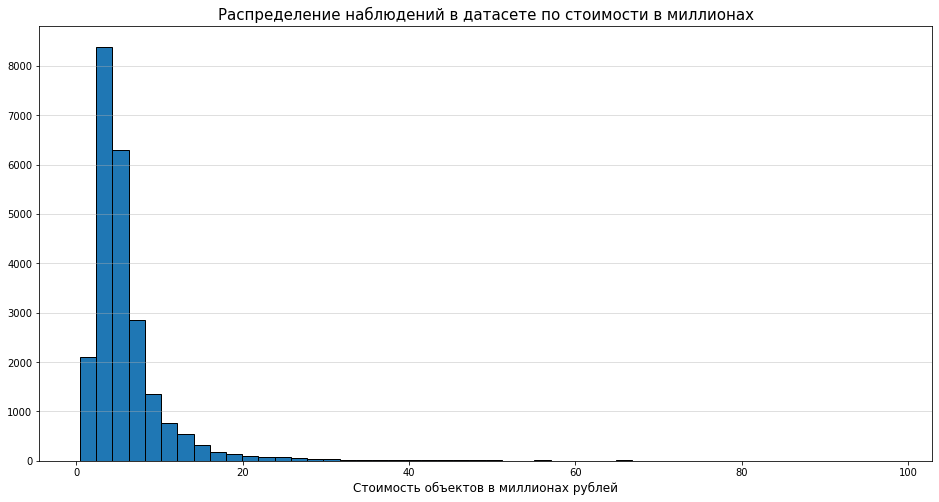

In [81]:
plt.figure(figsize=[16,8])
plt.hist(x=data[data['last_price_mlns'] <= 100]['last_price_mlns'], bins=50, ec='black')
plt.grid(axis='y', alpha=0.5)
plt.xlabel('Стоимость объектов в миллионах рублей',fontsize=12)
#plt.axvline(x=data[(~data['total_area'].isna())]['total_area'].median(), color='r', label='Median total area')
#plt.axvline(x=np.percentile(data['total_area'], 99), color='g', label='99th percentile')
#plt.legend()
plt.title('Распределение наблюдений в датасете по стоимости в миллионах', fontsize=15)
plt.show()

Как и следовало ожидать, мода распределения на шаге 2-4 миллиона рублей. То есть, это либо однокомнатная квартира в городе, либо двухкомнатная в пригороде. 

#### Анализ количества комнат

In [82]:
data['rooms'].describe()

count    23438.000000
mean         2.041642
std          0.976739
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          7.000000
Name: rooms, dtype: float64

Высказанные выше предположения о количестве комнат в наиболее распространнеых вариантах жилья находят подтверждение при оценки данных столбца:

1) Среднее и медианное значения практически одинаковы - 2 комнаты;

2) Отклонение - 1 комната

Анализ аномальных значений, заполнение пропусков и корректировка количества комнат уже были произведены.

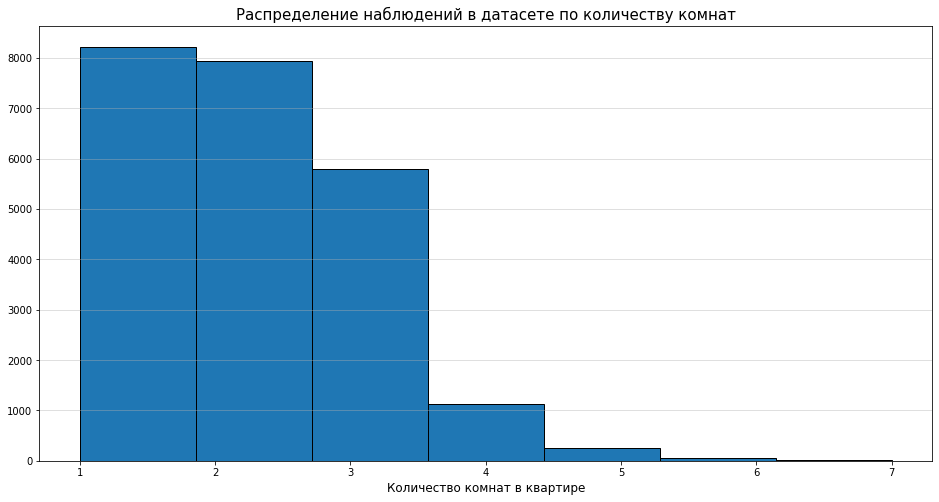

In [83]:
#ограничим количество корзин в гистограмме количеством возможных вариантов количества комнат в квартире - 7
plt.figure(figsize=[16,8])
plt.hist(x=data['rooms'], bins=int(data['rooms'].max()), ec='black')
plt.grid(axis='y', alpha=0.5)
plt.xlabel('Количество комнат в квартире',fontsize=12)
#plt.axvline(x=data['rooms'].median(), color='r', label='Median total area')
#plt.axvline(x=np.percentile(data['total_area'], 99), color='g', label='99th percentile')
#plt.legend()
plt.title('Распределение наблюдений в датасете по количеству комнат', fontsize=15)
plt.show()

Мы видим, что большая часть объявлений - это "народные" варианты в 1-2 комнаты (примерно 16 тысяч записей с незначительным преимуществом однокомнатных вариантов). Трехкомнатные квартиры также достаточно популярны, но количество таких объявление составляет примерно 75% от количества двухкомнатных (или однокомнатных) вариантов. С 4 комнат виден значительный "провал" - такой формат жилья уже доступен меньшему количеству покупателей. В относительных значения картина сопоставима и для пар 5-4 комнат, 6-5 комнат. 

#### Анализ высоты потолков

Ранее в рамках анализа также была произведена нормализация данных в столбце с высотами потолков, поэтому мы можем просто оценить полученный результат и понять, какие варианты в наибольшей степени популярны.

In [84]:
data['ceiling_height'].describe()

count    23438.000000
mean         2.715498
std          0.223713
min          2.200000
25%          2.550000
50%          2.700000
75%          2.800000
max          4.750000
Name: ceiling_height, dtype: float64

Как видим, метод describe действительно возвращает нам вполне реалистиные значения. Среднее и медианные значения находятся на одном уровне (2.6-2.7 метра). Не обладая экспертизой в области возможных планировок квартир и высот потолков, я бы сказал, что средняя высота довольно большая. Вероятно, на это влияет год постройки дома, но мы не располагаем соответствующими данными для проверки гипотезы. 

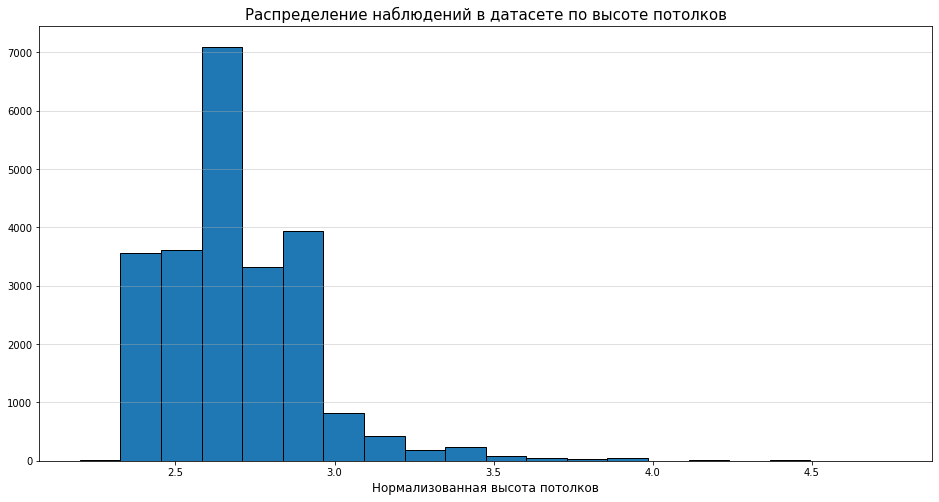

In [85]:
#ограничим количество корзин в гистограмме количеством возможных вариантов количества комнат в квартире - 7
plt.figure(figsize=[16,8])
plt.hist(x=data['ceiling_height'], bins=20, ec='black')
plt.grid(axis='y', alpha=0.5)
plt.xlabel('Нормализованная высота потолков',fontsize=12)
#plt.axvline(x=data['rooms'].median(), color='r', label='Median total area')
#plt.axvline(x=np.percentile(data['total_area'], 99), color='g', label='99th percentile')
#plt.legend()
plt.title('Распределение наблюдений в датасете по высоте потолков', fontsize=15)
plt.show()

Пиковое значение находится у отметки 2.6-2.7 метра. 

#### Анализ по времени продажи квартир

In [86]:
data['days_exposition'].loc[data['days_exposition'] > 0].describe()

count    20316.000000
mean       179.711656
std        218.330662
min          1.000000
25%         45.000000
50%         95.000000
75%        230.000000
max       1580.000000
Name: days_exposition, dtype: float64

В общем, 1 квартиль лежит на уровне 45 дней, но на уровне субъективной оценки - это довольно большой срок для недорогих "народных" вариантов жилья, поэтому на средние и медианные значения имеет смысль посмотреть через призму количества комнат в квартире. 

Необычно долгим же значение можно назвать все, что более 1 года (хотя 3 квартиль лежит на отметке в 230 дней). Субъективно, записи с временем продажи более 1 года вызывают вопросы относительно своей достоверности. 

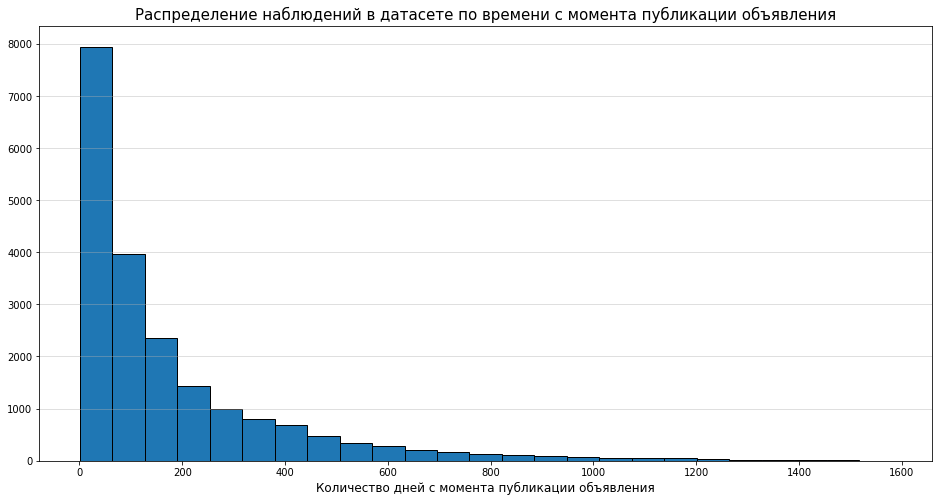

In [87]:
#ограничим количество корзин в гистограмме количеством возможных вариантов количества комнат в квартире - 7
plt.figure(figsize=[16,8])
plt.hist(x=data['days_exposition'].loc[data['days_exposition'] > 0], bins=25, ec='black')
plt.grid(axis='y', alpha=0.5)
plt.xlabel('Количество дней с момента публикации объявления',fontsize=12)
#plt.axvline(x=data['rooms'].median(), color='r', label='Median total area')
#plt.axvline(x=np.percentile(data['total_area'], 99), color='g', label='99th percentile')
#plt.legend()
plt.title('Распределение наблюдений в датасете по времени с момента публикации объявления', fontsize=15)
plt.show()

In [88]:
data.pivot_table(index=['urban_group', 'rooms'], values=['days_exposition', 'last_price_mlns'], aggfunc=['mean', 'median'])

mean                          median  \
                         days_exposition last_price_mlns days_exposition   
urban_group        rooms                                                   
Областной город    1          167.415833        2.728805            84.0   
                   2          181.107874        3.546827            98.0   
                   3          197.707835        4.603246           114.0   
                   4          237.623762        6.226142           155.0   
                   5          173.000000        7.555263           117.0   
                   6           96.000000       10.300000            96.0   
Санкт-Петербург    1          155.205895        4.448363            76.0   
                   2          171.015464        6.760507            90.0   
                   3          205.360942        9.488202           114.0   
                   4          257.502003       13.060880           155.0   
                   5          290.403409       16.106623           163.5   
                   6          281.150000       16.778246           192.0   
                   7          182.727273       18.682000           130.0   
Сельская местность 1          158.124321        2.852232            86.0   
                   2          173.300847        3.424043            97.5   
                   3          201.951140        4.435089           118.5   
                   4          235.016949        5.287143           172.0   
                   5          273.375000        6.451333           157.0   
                   6          357.500000       14.400000           357.5   

                                          
                         last_price_mlns  
urban_group        rooms                  
Областной город    1               2.650  
                   2               3.250  
                   3               4.150  
                   4               4.600  
                   5               5.900  
                   6              10.300  
Санкт-Петербург    1               4.070  
                   2               5.650  
                   3               7.160  
                   4               9.875  
                   5              12.945  
                   6              13.500  
                   7              16.750  
Сельская местность 1               2.900  
                   2               3.400  
                   3               4.400  
                   4               4.940  
                   5               5.500  
                   6              14.400

In [114]:
print('Количество удаленных из датасета наблюдений: {:.2%}'.format(1 - (len(data)/initial_dataset_lenght)))

Количество удаленных из датасета наблюдений: 1.10%


**Из полученной сводной таблицы можем сделать следующие выводы:**

1) Время продажи до 45 дней действительно можно считать хорошим. Условно, можно говорить о месяце как действительно "хорошем" времени продажи. Наша гипотеза не подтвердилась;

2) Мы видим, что "экономичные" варианты (1 и 2 комнаты) продаются максимально быстро в Санкт-Петербурге. Начиная с 3 и более комнат в квартире ситуация меняется - среднее время продажи для Санкт-Петербурга растет, а для области сокращается - вероятно; 

3) Обратная пропорциональная зависимость, вероятней всего, обусловлена средней стоимостью объекта недвижимости в Санкт-Петербурге и области (например, медианная стоимость двухкомнатной квартиры в СПб находится на уровне 4-5 комнатной квартиры в области). 

Все эти выводы, при необходимости, можно детализировать и уточнить через более глубокую сегментацию данных. 

#### Анализ факторов, влияющих на стоимость продажи квартиры

В числе факторов, от которых потенциально может зависить стоимость объекта, по условию задания следующие:

- Цена 1 квадратного метра недвижимости
- Число комнат
- Этаж (первый или последний)
- Удаленность от центра

Таким образом, пул значений для проверки будет ограничен следующими критериями:

- Этаж первый или последний (промежуточные значения не учитываем)
- Удаленность от центра должна быть указана


In [90]:
len(data.loc[(data['cityCenters_nearest'].isnull() == False) & (data['floor_quality'] != 'Другой')])

4257

Для надежности стоит проверить записей в датасете, которые имеют указанное значение расстояния до центра, но при этом не принадлежат к локации "Санкт-Петербург" для ответа на вопрос: "Не указано ли расстояние у таких записей до центра другого города". 

In [91]:
#Посмотрим, как распределились такие значения по населенным пунктам
data.loc[(data['cityCenters_nearest'].isnull() == False) & (data['locality_name'] != 'Санкт-Петербург'), 'locality_name'].value_counts()

п. Шушары             436
Пушкин                363
Колпино               336
п. Парголово          326
Петергоф              200
Сестрорецк            182
Красное Село          174
Ломоносов             132
Кронштадт              94
п. Металлострой        65
п. Стрельна            42
Не указано             41
Павловск               38
Зеленогорск            24
п. Понтонный           20
п. Сапёрный             6
п. Молодёжное           5
п. Репино               4
п. Песочный             4
п. Лисий Нос            3
п. Александровская      2
п. Мурино               2
п. Усть-Ижора           2
п. Белоостров           1
п. Петро-Славянка       1
п. Левашово             1
п. Щеглово              1
Name: locality_name, dtype: int64

Так как я не обладаю экспертизой в областных городах-сателлитах Санкт-Петербурга, посмотрим на среднее расстояние до центра города по этим населенным пунктам:

In [92]:
data.loc[(data['cityCenters_nearest'].isnull() == False) & (data['locality_name'] != 'Санкт-Петербург')]\
.pivot_table(index='locality_name', values='cityCenters_nearest')

,cityCenters_nearest
locality_name,
Зеленогорск,54617.583333
Колпино,32107.764881
Красное Село,30033.672414
Кронштадт,49192.617021
Ломоносов,50739.969697
Не указано,11278.902439
Павловск,33206.921053
Петергоф,35475.360000
Пушкин,28742.195592


Построим матрицу корреляции между интересующими нас параметрами каждого объекта недвижимости:

In [93]:
data.loc[(data['cityCenters_nearest'].isnull() == False) & (data['floor_quality'] != 'Другой')]\
[['last_price', 'price_per_sqm', 'total_area', 'rooms', 'floor', 'cityCenters_nearest']].corr()

,last_price,price_per_sqm,total_area,rooms,floor,cityCenters_nearest
last_price,1.000000,0.827793,0.599550,0.333698,0.070508,-0.219183
price_per_sqm,0.827793,1.000000,0.215544,-0.021565,0.110979,-0.297661
total_area,0.599550,0.215544,1.000000,0.766221,0.049230,-0.190944
rooms,0.333698,-0.021565,0.766221,1.000000,-0.073014,-0.161948
floor,0.070508,0.110979,0.049230,-0.073014,1.000000,-0.046394
cityCenters_nearest,-0.219183,-0.297661,-0.190944,-0.161948,-0.046394,1.000000


1) Видна довольна очевидная сильная корреляция между общей стоимостью объекта недвижимости и ценой 1 квадратного метра;

2) Присутствует слабая корреляция между количеством комнат и стоимостью объекта недвижимости - это вполне объяснимый факт, так как количество комнат не позволяет в полной мере охарактеризовать качество объекта в целом (например, комнаты могут быть многочисленными, но малогабаритными)

3) Наиболее интересная зависимость между расстоянием до центра города и стоимостью одного квадратного метра недвижимости - она слабая и отрицательная (то есть, уменьшение одного параметра влияет на рост другого), но довольно существенно выделяется на фоне остальных метрик, поэтому имеет смысл принимать ее во внимание при оценке недвижимости;

4) Очень слабая отрицательная корреляция между ценой объекта в общем и расстоянием от этого объекта до центра города, а также между расстоянием и количеством комнат. 

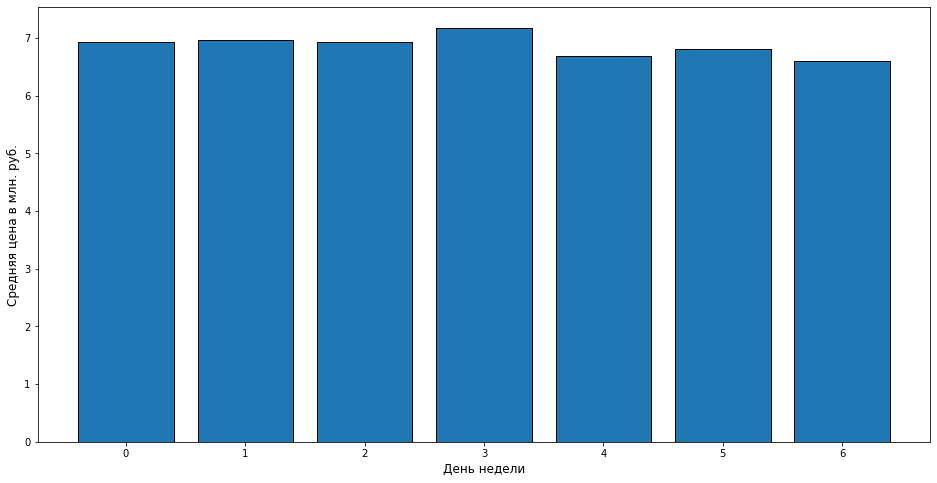

In [94]:
analysis = data.loc[(data['cityCenters_nearest'].isnull() == False)]\
.pivot_table(index='weekday_published', values='last_price_mlns').sort_values('weekday_published')
analysis = analysis.reset_index()

index = analysis['weekday_published']
values = analysis['last_price_mlns']

plt.figure(figsize=[16,8])
plt.bar(index, values, ec='black')
plt.ylabel('Средняя цена в млн. руб.',fontsize=12)
plt.xlabel('День недели',fontsize=12)
plt.show()

Средняя цена объекта недвижимости примерно равна и находится у отметки в 7 миллионов рублей. 

In [95]:
analysis = data.loc[(data['cityCenters_nearest'].isnull() == False),\
['first_day_exposition', 'last_price_mlns']]
analysis['month_published'] = pd.to_datetime(data['first_day_exposition']).dt.month
analysis['year_published'] = pd.to_datetime(data['first_day_exposition']).dt.year
#если в первом случае мы воспользовались днем недели, который добавили в исходный датафрейм изначально, то для
#построения графиков по месяцу и году используем отдельный небольшой датафрейм с нужными данными

analysis.sample(10)

,first_day_exposition,last_price_mlns,month_published,year_published
6023,2018-07-19,11.30,7,2018
655,2018-07-16,3.72,7,2018
20049,2016-05-29,3.85,5,2016
8088,2018-03-06,4.60,3,2018
17429,2017-11-21,31.49,11,2017
7119,2018-06-01,3.65,6,2018
14308,2018-10-03,4.00,10,2018
17662,2019-03-06,23.50,3,2019
7492,2017-07-27,2.80,7,2017
12662,2018-05-17,4.65,5,2018


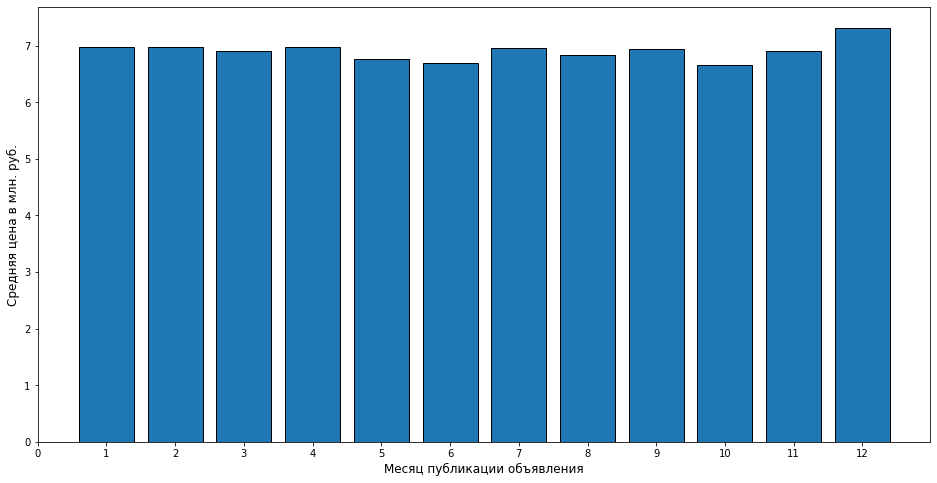

In [96]:
month_pivot = analysis.pivot_table(index='month_published', values='last_price_mlns').sort_values('month_published')
month_pivot = month_pivot.reset_index()

index = month_pivot['month_published']
values = month_pivot['last_price_mlns']

plt.figure(figsize=[16,8])
plt.bar(index, values, ec='black')
plt.ylabel('Средняя цена в млн. руб.',fontsize=12)
plt.xlabel('Месяц публикации объявления',fontsize=12)
plt.xticks(np.arange(0, 13, step=1))
plt.show()

По месяцам публикации также не удается увидеть какие-то значимые отличия. Единственное, что привлекает внимание - это колебания средней стоимости ближе к концу года. Вероятно есть некоторые изменения в активности спроса, но не столь существенные. 

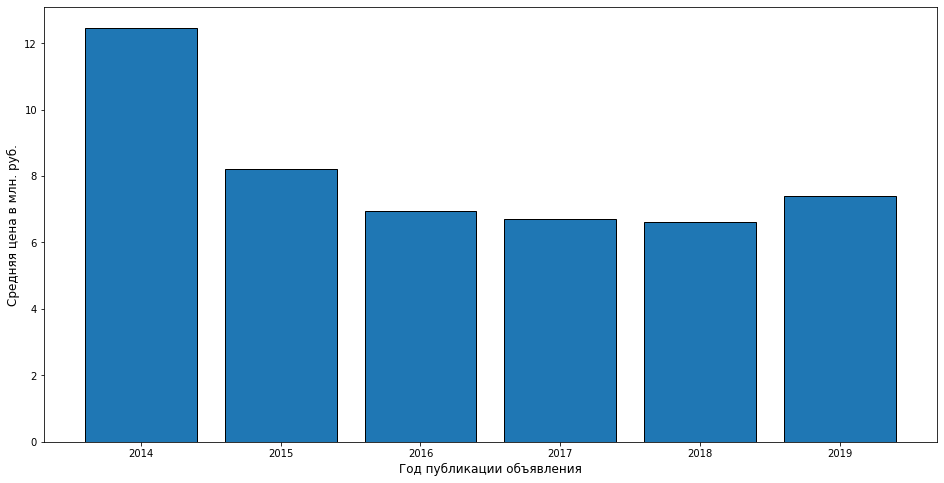

In [97]:
yr_pivot = analysis.pivot_table(index='year_published', values='last_price_mlns').sort_values('year_published')
yr_pivot = yr_pivot.reset_index()

index = yr_pivot['year_published']
values = yr_pivot['last_price_mlns']

plt.figure(figsize=[16,8])
plt.bar(index, values, ec='black')
plt.ylabel('Средняя цена в млн. руб.',fontsize=12)
plt.xlabel('Год публикации объявления',fontsize=12)
plt.show()

Наиболее выраженный перепад мы наблюдаем при анализе средней цены объекта недвижимости за год - мы видим двухкратное снижение в период между 2014 и 2015 годами. В 2016-2017 годах продолжается снижение, но минимальное. Можно предположить, что резкий спад обусловлен последствиями начавшегося экономического кризиса и резкого снижения доходов населения. Влоть до 2018 года средняя цена объекта недвижимости снижалась и только в 2019 году начала расти. 

Гипотеза: снижение стоимости на "люксовую" недвижимость вкупе с ростом спроса на бюджетные объекты - это два ключевых драйвера рыночной тенденции, представленной на графике. 

In [98]:
yr_pivot_2014 = analysis.loc[analysis['year_published'] == 2014].pivot_table(index='month_published',\
values='last_price_mlns')
display(yr_pivot_2014)

,last_price_mlns
month_published,
11,13.538000
12,12.239239


Мы видим, что располагаем информацией об опубликованных в 2014 году объявлениях только за два месяца: ноябрь и декабрь. Это менее 20% данных по году, поэтому выводы на базе этой информации будут еще менее точными. Однако, мы понимаем, что кризис в 2014 году начался ранее и такие цены на недвижимость в конце года - это попытка "заморозить" деньги, обсуловленная резким падением курса валюты. 

In [99]:
locality_top10 = pd.DataFrame.from_dict(data['locality_name'].value_counts().head(10).to_dict(), \
orient='index', columns=['rows'])
#отбираем 10 населенных пунктов с наибольшим количеством объявлений и записываем их в словарь, который преобразуем в
#датафрейм
locality_top10.reset_index(inplace=True)
locality_top10.columns=['locality_name', 'rows']

locality_top10.head(10)

,locality_name,rows
0,Санкт-Петербург,15487
1,п. Мурино,556
2,п. Шушары,440
3,Всеволожск,397
4,Пушкин,364
5,Колпино,337
6,п. Парголово,326
7,Гатчина,307
8,д. Кудрово,299
9,Выборг,235


In [100]:
data_grouped = data.groupby('locality_name')
data_grouped = data_grouped['last_price', 'price_per_sqm'].mean().astype(int)
#группируем исходный датафрейм по локации и считаем среднее по цене и цене за квадратный метр - на выходе получаем
#новый датафрейм с нужными параметрами и полным списком локаций из выборки

In [101]:
locality_top10 = locality_top10.join(data_grouped, on='locality_name')
#соеднияем два полученных датафрейма и получаем топ10 населенных пунктов с количеством объявлений, средней ценой и 
#средней ценой за квадратный метр
display(locality_top10)

,locality_name,rows,last_price,price_per_sqm
0,Санкт-Петербург,15487,7301796,113544
1,п. Мурино,556,3652361,85681
2,п. Шушары,440,4108081,78676
3,Всеволожск,397,3792818,68718
4,Пушкин,364,6153453,103122
5,Колпино,337,3866288,75332
6,п. Парголово,326,4477608,90331
7,Гатчина,307,3488336,68745
8,д. Кудрово,299,4234157,92473
9,Выборг,235,3260778,58237


Выводы:

1) Санкт-Петербург лидер по всем параметрам: больше всего объявлений, самая высокая средняя стоимость объекта недвижимости и самая высокая цена 1 квадратного метра;

2) На втором месте по стоимости с незначительным отрывом - Пушкин.  Эти два населенных пункта можно назвать самыми дорогими в нашем датасете. 

3) Самые "бюджетные" варианты располагаются во Всеволожске и Выборге. 

#### Анализ расстояния до ценра города

В соответствии с условиями поставленной задачи, нам необходимо добавить в таблицу новый столбец с расстоянием в километрах и округлить его до целых значений, однако ранее мы уже пересчитали значения исходного столбца в километры и округлили до 1 знака после точки из соображений упрощения восприятия значений в таблице, так как десятки и единицы метров в расстоянии до таких объектов вряд ли будут иметь принципиальное значение. Поэтому мы добавим новый столбец без пересчета, но с округлением до целого значения:

In [102]:
data['cityCenters_nearest_km'] = round(data['cityCenters_nearest'] / 1000, 0)
data.loc[data['locality_name'] == 'Санкт-Петербург']\
.pivot_table(index='cityCenters_nearest_km', values='last_price_mlns')
#по значениям исходного датасета, где в качестве локации указан Санкт-Петербург, мы строим сводную таблицу
#при этом, используем в качестве значений столбец с ценой объекта в миллионах - в противном случае
#данные о средней цене будут представлены в научной нотации, что затрудняет восприятие

,last_price_mlns
cityCenters_nearest_km,
0.0,23.804800
1.0,16.065434
2.0,13.563427
3.0,10.275103
4.0,10.760241
5.0,11.532964
6.0,12.414014
7.0,13.622244
8.0,8.936350


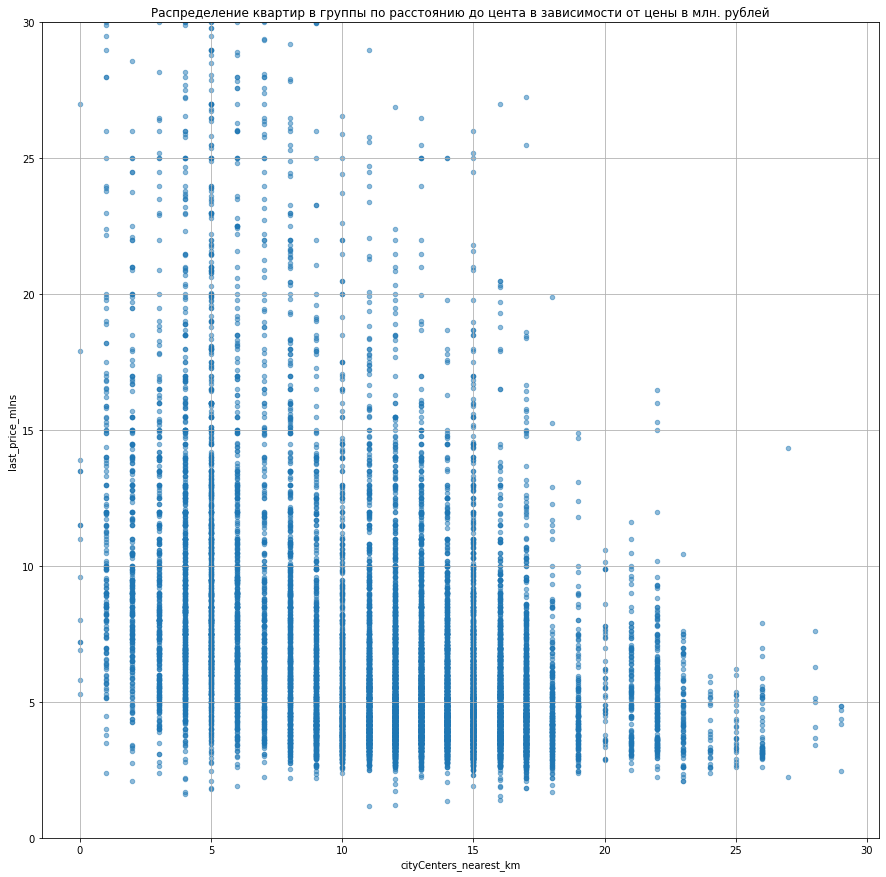

In [103]:
data.loc[data['locality_name'] == 'Санкт-Петербург'].plot(
    figsize=(15, 15),
    alpha=0.5, 
    grid=True, 
    y='last_price_mlns', 
    x='cityCenters_nearest_km',
    style='x', 
    ylim=(0, 30), 
    kind='scatter', 
    title='Распределение квартир в группы по расстоянию до цента в зависимости от цены в млн. рублей')
plt.show()

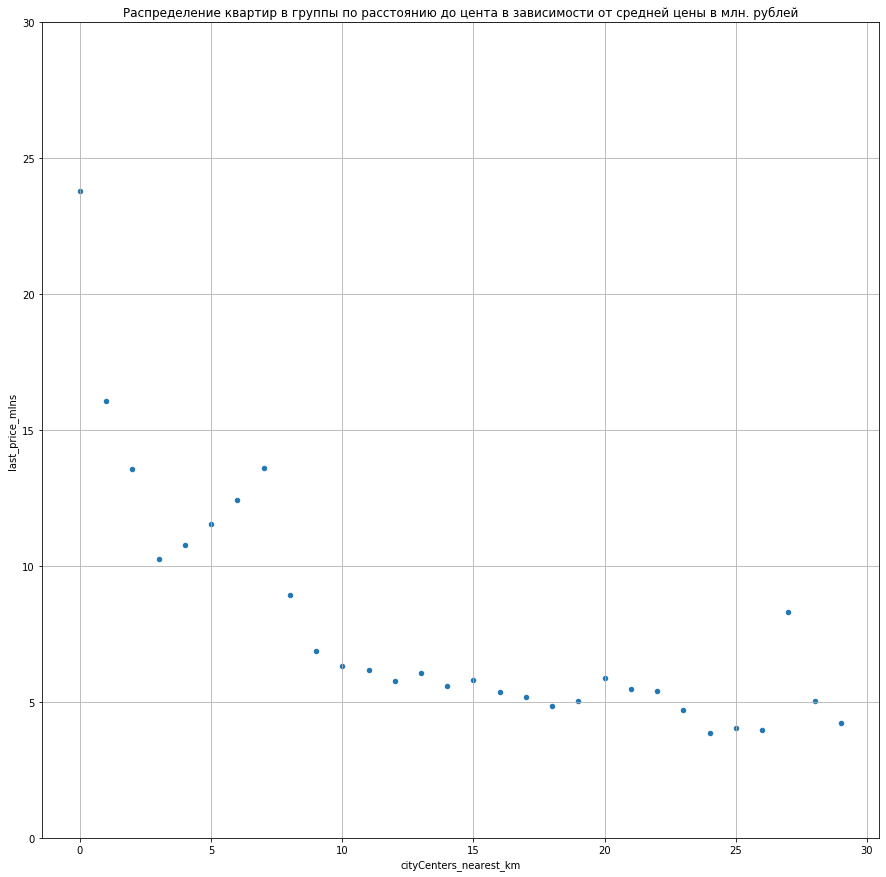

In [104]:
pivot_for_scatter = data.loc[data['locality_name'] == 'Санкт-Петербург'].pivot_table(
    index='cityCenters_nearest_km', 
    values='last_price_mlns')
pivot_for_scatter = pivot_for_scatter.reset_index()
pivot_for_scatter.plot(
    grid=True, 
    y='last_price_mlns', 
    x='cityCenters_nearest_km', 
    style='x', 
    figsize=(15, 15), 
    ylim=(0, 30), 
    kind='scatter',
    title='Распределение квартир в группы по расстоянию до цента в зависимости от средней цены в млн. рублей')

**Выводы:**

Судя по малому графику, "спальные районы" (то есть такие, в которых целенаправленно большую часть площади застраивают домами высокой плотности) начинаются примерно с 8 километра от центра. 

Однако на двух графиках видно, что "первый круг" центра - это отметка между 3 и 4 километром от центра (наиболее популярный сегмент жилья тут от 5 до 12-13 миллионов).

"Второй круг" - это отметка 8-9 километров - здесь линии становятся максимально плотными (много вариантов жилья). Кроме того, здесь существенно смещается к оси Y средняя стоимость объектов недвижимости - диапазон от 2.5 до 7.5 миллионов. 

#### Анализ "квартир в центре"

Построим сводную таблицу для анализа целевых параметров по сегменту "квартир в центре" в Санкт-Петербурге:

In [105]:
data.loc[(data['cityCenters_nearest_km'] <= 8) & (data['locality_name'] == 'Санкт-Петербург')].\
pivot_table(index='cityCenters_nearest_km', values=['total_area', 'last_price_mlns', 'rooms', 'ceiling_height'], \
aggfunc=['mean', 'median', 'count'])

mean                                        \
                       ceiling_height last_price_mlns     rooms  total_area   
cityCenters_nearest_km                                                        
0.0                          3.224000       23.804800  3.000000  107.600000   
1.0                          3.038439       16.065434  3.017341   89.094682   
2.0                          3.070804       13.563427  2.926573   89.538951   
3.0                          3.014516       10.275103  2.891496   85.234604   
4.0                          2.974398       10.760241  2.837349   85.394940   
5.0                          2.948443       11.532964  2.655133   83.457636   
6.0                          2.862457       12.414014  2.384083   77.460917   
7.0                          2.819634       13.622244  2.385366   76.768610   
8.0                          2.796944        8.936350  2.256367   69.918557   

                               median                                   \
                       ceiling_height last_price_mlns rooms total_area   
cityCenters_nearest_km                                                   
0.0                              3.20           13.90     3     98.000   
1.0                              2.95           10.20     3     83.000   
2.0                              2.95            9.50     3     83.250   
3.0                              2.95            8.30     3     78.600   
4.0                              2.95            8.99     3     78.000   
5.0                              2.95            9.00     3     77.000   
6.0                              2.85            8.50     2     69.300   
7.0                              2.80            7.65     2     67.885   
8.0                              2.75            7.40     2     62.000   

                                count                                   
                       ceiling_height last_price_mlns rooms total_area  
cityCenters_nearest_km                                                  
0.0                                25              25    25         25  
1.0                               173             173   173        173  
2.0                               286             286   286        286  
3.0                               341             341   341        341  
4.0                               664             664   664        664  
5.0                               867             867   867        867  
6.0                               578             578   578        578  
7.0                               410             410   410        410  
8.0                               589             589   589        589

**Выводы:**

1) В сегменте бюджетных квартир самая высота потолка находится у отметки в 2.7-2.8 метра. В центральной части эта цифра стремится к 3 метрам с небольшим снижением по мере удаления от центра: вероятно, высокие потолки - это историческое наследие. Снижение высоты потолков объясняется типовой советской застройкой (предполагаю, активно она начинается с 5-6 километра от центра)

2) В отличие от центрообразуещей отметки в 5 миллионов за квартиру в бюджетном сегменте и среднего значение всей выборки в 6.4 миллиона, стоимость жилья в центре по медиане выше до двух раз, а среднее значение в центре и вовсе выше в 2-3 раза, что говорит нам о существенном разрыве в стоимости двух сегментов и высоком престиже проживания в центре города 

3) Количество комнат у квартир в центре также больше, чем у бюджетных вариантов: ранее мы определили, что 2 комнаты - это одновременно и среднее и медианное значение для всей выборки. Такой формат наиболее популярен в бюджетном сегменте, хотя трехкомнатные квартиры также пользуются популярностью - вероятно, "для расширения площади" в силу житейских обстоятельств (например, с рождением детей). В центре же комнат обычно больше на 1 - и среднее и медианное значению тяготеют к отметке в 3 комнаты. Вероятно, это можно объяснить общей состоятельностью покупателей таких объектов недвижимости

4) Ранее было установлено, что для бюджетных вариантов можно выделить 3 наиболее популярных типоразмера квартир по площади (цифры ориентировочные): 35, 42 и 50 квадратных метров. Медиана для выборки - 52 квадратных метра. В случае квартир в центре мы можем выделить два важных момента: медианная и средняя площадь "квартир в центре" тем больше, чем ближе квартире к центру города - это объяснимо снижением приоритета "вопроса денег" над уровнем комфорта для покупателей таких объектов недвижимости; медианная площадь квартиры примерно на 30-60% больше, чем в сегменте бюджетного жилья. 

In [106]:
data.loc[(data['locality_name'] == 'Санкт-Петербург') & (data['floor_quality'] != 'Другой') &\
         (data['cityCenters_nearest_km'] <=8)]\
[['last_price', 'price_per_sqm', 'total_area', 'rooms', 'floor', 'cityCenters_nearest']].corr()
#посмотрим на корреляцию для центра СПб

,last_price,price_per_sqm,total_area,rooms,floor,cityCenters_nearest
last_price,1.000000,0.868563,0.530900,0.263153,0.192255,-0.080469
price_per_sqm,0.868563,1.000000,0.181101,-0.048436,0.157021,-0.034461
total_area,0.530900,0.181101,1.000000,0.787004,0.273038,-0.191940
rooms,0.263153,-0.048436,0.787004,1.000000,0.084817,-0.190937
floor,0.192255,0.157021,0.273038,0.084817,1.000000,0.148021
cityCenters_nearest,-0.080469,-0.034461,-0.191940,-0.190937,0.148021,1.000000


In [107]:
data.loc[(data['locality_name'] == 'Санкт-Петербург') & (data['floor_quality'] != 'Другой') &\
         (data['cityCenters_nearest_km'] > 8)]\
[['last_price', 'price_per_sqm', 'total_area', 'rooms', 'floor', 'cityCenters_nearest']].corr()
#и такая же матрица корреляции, но для квартир за пределами "центра"

,last_price,price_per_sqm,total_area,rooms,floor,cityCenters_nearest
last_price,1.000000,0.545311,0.821031,0.452011,0.147820,-0.073579
price_per_sqm,0.545311,1.000000,0.034413,-0.246895,0.248780,-0.212196
total_area,0.821031,0.034413,1.000000,0.734631,0.055527,0.035651
rooms,0.452011,-0.246895,0.734631,1.000000,-0.112770,-0.027138
floor,0.147820,0.248780,0.055527,-0.112770,1.000000,0.019958
cityCenters_nearest,-0.073579,-0.212196,0.035651,-0.027138,0.019958,1.000000


**Есть несколько заметных отличий:**

1. Для центра СПб наблюдается сильная корреляция между стоимость 1 квадратного метра и общей стоимостью квартиры. Для квартир за пределами центра она падает ниже среднего. Это обусловлено меньшей площадью "центра" и более высокой концентрацией объектов недвижимости в нем - выше "конкуренция" за 1 кв. м.

2. Но наблюдается противоположная тенденция - зависимость между общей площадью и ценой становится значительно более выраженной - в бюджетном сегменте люди предпочитают получить больше метров за свои деньги. Учитывае ранее сформулированный вывод о средней площади и количестве комнат в бюджетном и люксовом сегментах, это вполне объяснимо: покупка двухкомнатной квартиры в 45-50 квадратов существенно улучшает жилищные условия, если ранее речь шла о варианте в 1 комнату площадью 30-35 квадратных метров;

3. От слабых значение к условно "слабо-средним" поднимается зависимость цены от количества комнат в бюджетном сегменте

In [108]:
analysis = data.loc[(data['cityCenters_nearest'].isnull() == False) & (data['cityCenters_nearest_km'] <= 8) ,['first_day_exposition', 'last_price_mlns']]
analysis['weekday_published'] = pd.to_datetime(data['first_day_exposition']).dt.dayofweek
analysis['month_published'] = pd.to_datetime(data['first_day_exposition']).dt.month
analysis['year_published'] = pd.to_datetime(data['first_day_exposition']).dt.year

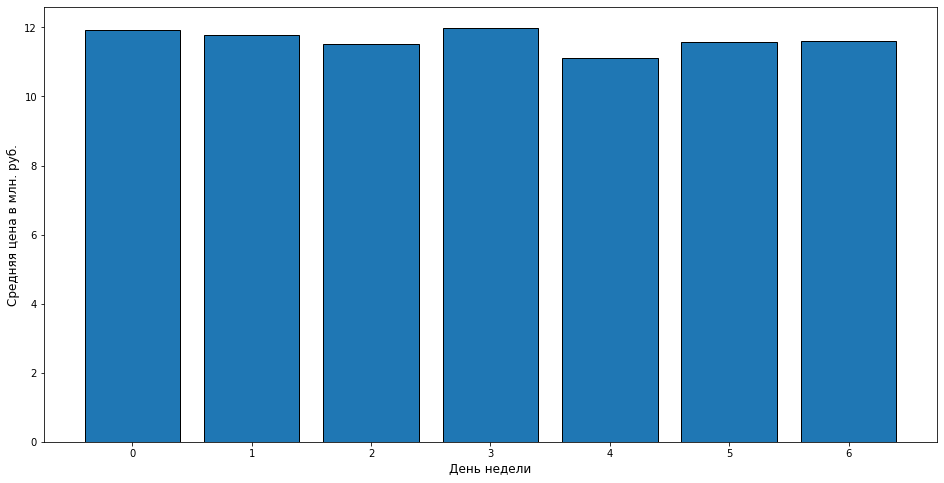

In [109]:
weekday_pivot = analysis.pivot_table(index='weekday_published', values='last_price_mlns')
weekday_pivot = weekday_pivot.reset_index()

index = weekday_pivot['weekday_published']
values = weekday_pivot['last_price_mlns']

plt.figure(figsize=[16,8])
plt.bar(index, values, ec='black')
plt.ylabel('Средняя цена в млн. руб.',fontsize=12)
plt.xlabel('День недели',fontsize=12)
plt.show()

Аналогичная картина - существенных колебаний в разрезе недели не наблюдается.

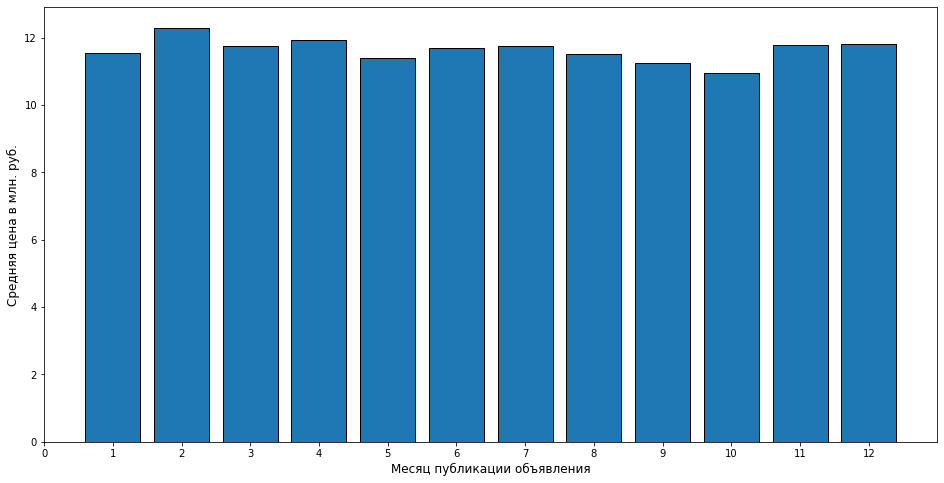

In [110]:
month_pivot = analysis.pivot_table(index='month_published', values='last_price_mlns')
month_pivot = month_pivot.reset_index()

index = month_pivot['month_published']
values = month_pivot['last_price_mlns']

plt.figure(figsize=[16,8])
plt.bar(index, values, ec='black')
plt.ylabel('Средняя цена в млн. руб.',fontsize=12)
plt.xlabel('Месяц публикации объявления',fontsize=12)
plt.xticks(np.arange(0, 13, step=1))
plt.show()

Аналогично: в целом средняя стоимость объекта стабильна и находится в районе 11-12 миллионов.

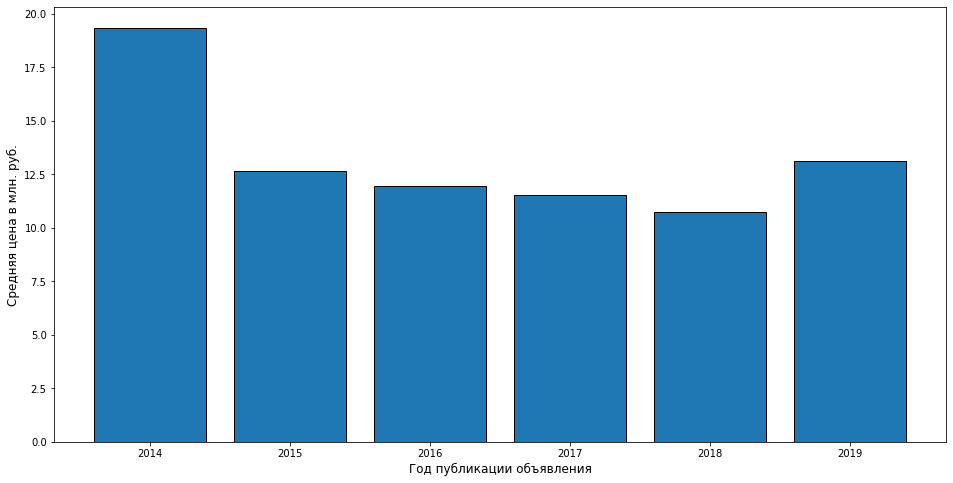

In [111]:
yr_pivot = analysis.pivot_table(index='year_published', values='last_price_mlns')
yr_pivot = yr_pivot.reset_index()

index = yr_pivot['year_published']
values = yr_pivot['last_price_mlns']

plt.figure(figsize=[16,8])
plt.bar(index, values, ec='black')
plt.ylabel('Средняя цена в млн. руб.',fontsize=12)
plt.xlabel('Год публикации объявления',fontsize=12)
plt.show()

Тенденция к спаду в период 2014-2015 годов сохраняется для элитного жилья. Более того, учитывая влияние цен дорогих объектов недвижимости на общую величину среднего, можно сформулировать гипотезу: спад средней цены объекта недвижимости в 2014-2015 годах произошел в большей степени за счет снижения спроса на люксовые квартиры.

## Общий вывод

**Общие выводы по проекту:**

1. Установлено, что квартиры, в целом, можно разделить на два вида: **дорогие** в центре города и **бюджетные**, расположенные в других районах города или пригороде;

2. Условная средняя квартира бюджетного сегмента имеет ряд характерных признаков: площадь в диапазоне 30-50 квадратных метров; количество комнат 1-2, высота потолков около 2.5 метров;

3. Условная средняя квартира в центре города также имеет ряд характерных признаков: площадь 70-100 квадратных метров, не менее 3 комнат, высота потолков 2.7 метра и выше;

4. Самый "дешевый" этаж - 1 (медианная цена объекта недвижимости тут - 3.9 млн. рублей). Самый "дорогой" этаж - 30 (медианная цена объекта - 10.15 млн. рублей)

4. Наиболее важные факторы для квартир бюджетного сегмента: цена объекта, цена квадратного метра, общая площадь объекта. Люди готовы жертвовать расстоянием до центра города и инфраструктурных объектов для получения большей площади за свои деньги;

5. Наиболее важные факторы для "дорогих" квартир: площадь, количество комнат, высота потолков, удаленность от центра города и инфраструктурных объектов;

6. Для дорогих и дешевых квартир наблюдается интересная зависимость: на цену объекта в бюджетном сегменте в большей степени влияет общее количество квадратных метров, в то время как в дорогом сегменте усиливается влияение стоимости 1 квадратного метра;

7. Выявлено, что в сегмент "дорогих" квартир входят те, расстояние у которых до центра города равно или менее 8 километров. При этом, по расстоянию до центра города этот сегмент делится на две части 0-4 километра от центра города и 4-8 километров от центра города;

8. По аналогии, в бюджетном сегменте также можно выделить две группы: областные города (города сателлиты) и селькая местность (различные поселки, деревни и села). В среднем, в сельской местности ниже время размещения объявления для квартир с более чем 4 комнатами. При наличии данных о типе объекта недвижимости можно было бы проверить гипотезу, являются ли "многокомнатные" объекты недвижимости домами;

9. Если исключить из выборки Санкт-Петербург, то наиболее популярные населенные пункты: п. Мурино, п. Шушары, г. Всеволожск, г. Пушкин. При этом, Всеволожск среди приведенных отличается значительно меньшей средней стоимостью 1 квадратного метра жилья: порядка 70 тысяч против 80-100 в других населенных пунктах.
